In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

/Users/vladarozova/handsonml2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Weight initialization

In [2]:
# One should generally initialize weights with a small amount of noise
# for symmetry breaking, and to prevent 0 gradients.

def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

Bias initialization

In [3]:
# Since we're using ReLU neurons, it is also good practice to initialize
# them with a slightly positive initial bias to avoid "dead neurons"

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Convolutional and pooling layers

In [4]:
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

Create a grapf for the CNN

In [5]:
def deepnn(x):
    """deepnn builds the graph for a deep net for classifying digits.
    Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.
    Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
    """
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    with tf.name_scope("Deep_CNN") as scope:
        x_image = tf.reshape(x, [-1, 28, 28, 1])

        # First convolutional layer - maps one grayscale image to 32 feature maps.
        with tf.name_scope("Conv_layer") as scope:
            W_conv1 = weight_variable([5, 5, 1, 32])
            b_conv1 = bias_variable([32])
            h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

        # Pooling layer - downsamples by 2X.
        h_pool1 = max_pool_2x2(h_conv1)

        # Second convolutional layer -- maps 32 feature maps to 64.
        with tf.name_scope("Conv_layer") as scope:
            W_conv2 = weight_variable([5, 5, 32, 64])
            b_conv2 = bias_variable([64])
            h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

        # Second pooling layer.
        h_pool2 = max_pool_2x2(h_conv2)

        # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
        # is down to 7x7x64 feature maps -- maps this to 1024 features.
        with tf.name_scope("FC_layer") as scope:
            W_fc1 = weight_variable([7 * 7 * 64, 1024])
            b_fc1 = bias_variable([1024])

            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        # Dropout - controls the complexity of the model, prevents co-adaptation of
        # features.
        with tf.name_scope("Dropout") as scope:
            keep_prob = tf.placeholder(tf.float32)
            h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        # Map the 1024 features to 1 classes, one for digit 5
        with tf.name_scope("Readout") as scope:
            W_fc2 = weight_variable([1024, 10])
            b_fc2 = bias_variable([10])

            y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            
    return y_conv, keep_prob

Import data

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train = mnist.train.images  # Returns np.array
y_train = np.asarray(mnist.train.labels, dtype=np.int64)
X_test = mnist.test.images  # Returns np.array
y_test = np.asarray(mnist.test.labels, dtype=np.int64)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Create training and test sets

Extract batches

In [7]:
def batch_with_reps(X_train, y_train, batch_size):
    rnd_ind = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_ind, :]
    y_batch = y_train[rnd_ind]
    return X_batch, y_batch

Reset a graph

In [8]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [9]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Construction phase

In [10]:
reset_graph()
logdir = log_dir("CNN")

n_features = 28 * 28

# Create a model
X = tf.placeholder(tf.float32, shape=[None, n_features], name="X")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
y_conv, keep_prob = deepnn(X)
y_proba = tf.nn.softmax(y_conv)

# Define loss
with tf.name_scope("Train") as scope:
    learning_rate = 1e-4
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_conv), name="loss")
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

# Measure performance
with tf.name_scope("Eval") as scope:
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

# Where to add summary
with tf.name_scope("Summary") as scope:
    loss_summary = tf.summary.scalar('Cross_entropy', loss)
    accuracy_summary = tf.summary.scalar('Training_accuracy', accuracy)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Execution phase

In [11]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 4
batch_size = 50
n_batches = int(np.ceil(len(X_train) / batch_size))

checkpoint_path = "/tmp/my_deep_cnn.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_cnn"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
    # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = batch_with_reps(X_train, y_train, batch_size)
            training_op.run(feed_dict={X: X_batch, y: y_batch, keep_prob: 0.5})
            if batch_index % 100 == 0:
                train_accuracy, summary_str = sess.run([accuracy, accuracy_summary], 
                                                       feed_dict={X: X_batch, y: y_batch, keep_prob: 1.0})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
        # Calculate loss after each epoch
        loss_val, summary_str = sess.run([loss, loss_summary], 
                                         feed_dict={X: X_test, y: y_test, keep_prob: 1.0})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 2 == 0:
            print('Epoch:', epoch, '\tTraining accuracy:', train_accuracy)
            print('Loss:', loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val, test_accuracy = sess.run([y_proba, accuracy], 
                                          feed_dict={X: X_test, y: y_test, keep_prob: 1.0})
    print('Test accuracy:', test_accuracy)
    os.remove(checkpoint_epoch_path)
    
file_writer.close()

Epoch: 0 	Training accuracy: 0.96
Loss: 0.10781528
Epoch: 2 	Training accuracy: 0.94
Loss: 0.050321672
Test accuracy: 0.9856


Peformance measures

In [12]:
y_pred = (y_proba_val[:, 5] >= 0.98)
y_pred[:5]

array([False, False, False, False, False])

In [13]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test[:, 5], y_pred)

0.9987834549878345

In [14]:
recall_score(y_test[:, 5], y_pred)

0.9204035874439462

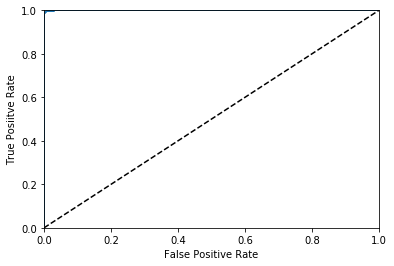

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test[:, 5], y_proba_val[:, 5])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posiitve Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

Remove last saved checkpoint

In [16]:
 os.remove(checkpoint_epoch_path)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/my_deep_cnn.ckpt.epoch'